In [1]:
####################################################################################
# Abraham Tishelman-Charny                                                         #
# 16 March 2021                                                                    #
#                                                                                  #
# The purpose of this notebook is to analyze ETT Analyzer output root files.       #
####################################################################################

In [2]:
##-- Imports 
import uproot ##-- If uproot isn't installed, on lxplus run: pip install --user uproot 
import numpy as np 
from matplotlib.colors import LogNorm
from matplotlib import pyplot as plt 

In [3]:
##-- Common Definitions 

##-- Get units from variable name 
def GetUnits(v):
    UnitDict = {
        "Emulated_BX0_TP_ET" : "GeV",
        "Real_TP_ET" : "GeV",
    }
    return UnitDict[v]

##-- Print tree branches via uproot object 
def PrintBranches(tree):
    branches = tree.keys()
    print(branches)    

##-- For plotting 1d variable distributions 
def Plot1D(filePath, variables, ol, outLabel, Sev, Config):
    print("filePath:",filePath)
    print("outLabel:",outLabel)
    
    ##-- for binning: xmin, xmax, nBins
    VarBinDict = {
        "twrADC" : [0, 130, 65],
        "eRec" : [0, 300, 300],
        "time" : [0, 250, 250],
        "twrEmul3ADC" : [0, 130, 65]
    }    
    
    ##-- Human readable variable names. Could also be changed in ETTAnalyzer branch names 
    VarNameDict = {
        "twrADC" : "Real_TP_ET",
        "twrEmul3ADC" : "Emulated_BX0_TP_ET"
    }
    
    ##-- Severity word to number (string)
    SevDict = {
        "zero" : "0", 
        "three" : "3",
        "four" : "4"
    }
    
    ##-- Open ETTAnalyzer output with uproot 
    file = uproot.open(filePath)    
    tree = file['tuplizer']['ETTAnalyzerTree']
    
    ##-- For each variable, plot 
    for var in variables:
#         print("--> variable:",var)
        values_ = tree[var].array()
        values = [val for event in np.copy(values_) for val in event] ##-- combine values from all events into one list 
        xmin, xmax, xbins = VarBinDict[var]
        xbinSpace = np.linspace(xmin, xmax, xbins + 1)

        ##-- Convert TT ADC (not really ADC but max bit or something like that) to GeV 
        if(var == "twrADC" or var == "twrEmul3ADC"):
            VarName = VarNameDict[var] 
            ##-- Need to loop events and TTs to get all eta, phi values 
#             twrADC = twrADC[sevlv != -999]
#             twrADC = twrADC[twrADC >= 32]
            values = [val / 2. for val in values] ##-- 'ADC' to GeV 

        else: 
            VarName = var[:]
            # exec("values = var[sevlv != -999]") ##-- In case you want additional cuts 

        ##-- Get mean and stdev
        mean = round(np.mean(values), 5)
        stdev = round(np.std(values), 5)
        CMSSW_Version = outLabel.split('_Sev')[0]
        SevNum = SevDict[Sev]
        if(Config != ""):
            textstr = '\n'.join((
                CMSSW_Version,
                "Sev = %s"%(SevNum),
                "Config: %s"%(Config),
                r'$\mu=%.4f$' % (mean, ),
                r'$\sigma=%.4f$' % (stdev, )))   
        else:
            textstr = '\n'.join((
                CMSSW_Version,
                "Sev = %s"%(SevNum),
                r'$\mu=%.4f$' % (mean, ),
                r'$\sigma=%.4f$' % (stdev, )))    

        ##-- Plot variable
        fig, ax = plt.subplots()
        plt.rc('axes', axisbelow=True)        
        plt.hist(values, bins = xbinSpace)
        unit = GetUnits(VarName)
        plt.title(VarName)
        plt.xlabel("%s [%s]"%(VarName, unit))
        plt.ylabel("Entries [A.U.]")
        plt.yscale('log')
        plt.grid(True)
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        
        ##-- Text box in upper left in axes coords
        ax.text(0.4, 0.95, textstr, transform=ax.transAxes, fontsize=14,
                verticalalignment='top', bbox=props)  
        plt.show()
        plt.savefig("%s/%s_%s.png"%(ol, VarName, outLabel))
        plt.savefig("%s/%s_%s.pdf"%(ol, VarName, outLabel))
        plt.close()     

In [4]:
##-- Plot ratio of a variable between ETTAnalyzer root files 
##-- Used for plotting ratio of quantities between CMSSW instances 

def Ratio(files, label_1, label_2, Sev, typeLabel, ol, variable):
    Nfiles = len(files)
    
    ##-- Bin info (min, max, nBins) -- Overwritten for twrEmul3ADC
    VarBinDict = {
        "twrADC" : [0, 130, 65],
        "eRec" : [0, 300, 300],
        "time" : [0, 250, 250],
        "twrEmul3ADC" : [0, 130, 65]
    }    
    
    ##-- Name dictionary for variables to something more readable. Could also be changed in ETTAnalyzer 
    VarNameDict = {
        "twrADC" : "Real_TP_ET",
        "twrEmul3ADC" : "Emulated_BX0_TP_ET"
    }
    
    ##-- Severity level as a string, number of events in original Raman files. Should also be updated to read number of events from files 
    SevDict = {
        "zero" : ["0", 854, "Signal-Like"], 
        "three" : ["3", 23, "Spike-Like"],
        "four" : ["4", 127, "Spike-Like"],
        "threefour" : ["3, 4", 150, "Spike-Like"]
        
    }
    
    ##-- Begin accessing input files 
    SevNum, nEvents, SevString = SevDict[Sev]
    print("Getting variable values...")
    
    ##-- Two total files if there is one severity zero file per CMSSW config for comparing signal-like event distributions 
    if(Nfiles == 2):
        file1, file2 = files[0], files[1]
        print("file1:",file1)
        print("file2:",file2)
        f1 = uproot.open(file1)
        f2 = uproot.open(file2)
        EmuTP1 = f1['tuplizer']['ETTAnalyzerTree'][variable].array() ##-- Assuming Tdirectory / tree stucuture in root file: tuplizer/ETTAnalyzerTree 
        EmuTP2 = f2['tuplizer']['ETTAnalyzerTree'][variable].array()
#         print("EmuTP1:",EmuTP1) ##-- Print to check, but may not be able to see all non-zero values 
#         print("EmuTP2:",EmuTP2)
        
    ##-- Four total files if there are two severity files per CMSSW config (severity 3 and 4) for comparing spike-like event distributions 
    elif(Nfiles == 4):
        file1, file2, file3, file4 = files[0], files[1], files[2], files[3]
        f1 = uproot.open(file1)
        f2 = uproot.open(file2)
        f3 = uproot.open(file3)
        f4 = uproot.open(file4)        
        EmuTP1_ = f1['tuplizer']['ETTAnalyzerTree'][variable].array()
        EmuTP2_ = f2['tuplizer']['ETTAnalyzerTree'][variable].array()  
        EmuTP3_ = f3['tuplizer']['ETTAnalyzerTree'][variable].array()
        EmuTP4_ = f4['tuplizer']['ETTAnalyzerTree'][variable].array() 
        
        ##-- combine severity 3 and 4 TPs into single array 
        EmuTP1 = np.concatenate((EmuTP1_, EmuTP2_)) ##-- For first CMSSW config 
        EmuTP2 = np.concatenate((EmuTP3_, EmuTP4_)) ##-- For second CMSSW config 
        
    ##-- Get variable and bin information 
    VarName = VarNameDict[variable] 
    binInfo = VarBinDict[variable]
    bins = [val*4. for val in range(0,15)]
    extraBins = [150,256]
    extraBinsGeV = [val / 2. for val in extraBins]
    for eb in extraBinsGeV:
        bins.append(eb)
    print("bins:",bins)
    values1_ = [val for event in np.copy(EmuTP1) for val in event] ##-- combine values from all events into one list
    values2_ = [val for event in np.copy(EmuTP2) for val in event] ##-- combine values from all events into one list
    values1 = [val / 2. for val in values1_] ##-- 'ADC' to GeV 
    values2 = [val / 2. for val in values2_] ##-- 'ADC' to GeV 

    values1_a = np.array(values1, dtype = float)
    values2_a = np.array(values2, dtype = float)
    
    print("NUMBER OF TPs:",values1_a)
    nTPs = len(values1_a)
    
    ##-- Produce numpy histograms to obtain bin heights 
    print("Producing numpy histograms...")
    EmuTP1_bin_vals, bins_ = np.histogram(values1_a, bins = bins)
    EmuTP2_bin_vals, bins_ = np.histogram(values2_a, bins = bins)
    
    binvalues1_a = np.array(EmuTP1_bin_vals, dtype = float)
    binvalues2_a = np.array(EmuTP2_bin_vals, dtype = float)    
    
    ##-- Get ratio of bins 
    print("Taking ratio...")
    ratio = np.true_divide(binvalues1_a , binvalues2_a, out = np.zeros_like(binvalues2_a), where = binvalues2_a != 0)
    
    ##-- Get error on each bin ratio 
    ratio_errors = []
    for i, ratio_val in enumerate(ratio):
        val_1 = binvalues1_a[i] 
        val_2 = binvalues2_a[i]
        if(val_2 == 0): 
            ratio_errors.append(0)
            continue 
        else:
            error1 = np.sqrt(val_1)
            error2 = np.sqrt(val_2)
            ratio_error = ratio_val * np.sqrt((error1/val_1)**2 + (error2/val_2)**2)
            ratio_errors.append(ratio_error)
        
    ##-- Overlay two plots and plot ratio 
    fig, axarr = plt.subplots(2, 
                                sharex=True, 
                                gridspec_kw={
                                    'hspace': 0.15,
#                                     'height_ratios': (0.8,0.2)
                                    'height_ratios': (0.7,0.3)
                                    }
                                )     
      
    
    upper = axarr[0] ##-- Upper axis. Will contain two distributions, one for each CMSSW config 
    lower = axarr[1] ##-- Lower axis. Will contain ratio of two upper distributions 
    lower.grid(True)
    
    ##-- Upper left plot text
    ##-- CMS 
    plt.text(
        # 0.05, 0.9, u"CMS $\it{Preliminary}$",
        0., 1., u"CMS ",
        fontsize=18, fontweight='bold',
        horizontalalignment='left',
        verticalalignment='bottom',
        transform=upper.transAxes
    )
    
    ##-- Preliminary 
    plt.text(
        # 0.05, 0.9, u"CMS $\it{Preliminary}$",
        0.11, 1., u"Preliminary",
        fontsize=18,
        horizontalalignment='left',
        verticalalignment='bottom',
        transform=upper.transAxes
    )

    ##-- sqrt(s)
#     plt.text(
#             1., 1., r"%1.0f fb$^{-1}$ (13 TeV)" % 137,
#             fontsize=14, horizontalalignment='right',
#             verticalalignment='bottom',
#             transform=ax.transAxes
#     )      
    
    ##-- Create pyplot figure and plot one histogram per CMSSW config in upper, ratio of the two in lower 
    fig.set_size_inches(8, 6)
    
    ##-- Plot distribution for each CMSSW config 
    upper.hist(values1_a, bins = bins, histtype = 'step', label = label_1, alpha = 1)
    upper.hist(values2_a, bins = bins, histtype = 'step', label = label_2, alpha = 1)
    
    ##-- Decorate plot 
    plt.xlabel("Emulated TP [GeV]")
    plt.ylabel("Entries")  
    upper.set_ylabel("Entries", fontsize = 15)
    upper.set_yscale('log')
    
    ##-- Plot ratio of two histograms in lower section of canvas 
    bin_centers = [ (((float(bins[i+1]) - float(bins[i])) / 2.) + float(bins[i])) for i in range(0, len(bins)-1)]
    lower.plot([binInfo[0],binInfo[1]],[1,1],linestyle=':', color = 'black')
    xerr = [ ((float(bins[i+1]) - float(bins[i])) / 2.) for i in range(0, len(bins) - 1)]  
    zero_errors = [0 for entry in ratio_errors] ##-- for no errors 
    lower.errorbar(bin_centers, ratio, xerr = zero_errors , yerr = zero_errors, marker = '.', color = 'black', ls = '') #drawstyle = 'steps-mid') ##-- For no ratio error bars 
#     lower.errorbar(bin_centers, ratio, xerr = xerr , yerr = ratio_errors, marker = '.', color = 'black', ls = '') #drawstyle = 'steps-mid') ##-- To add statistical ratio error bars  

    ##-- Further decorate plot 
    lower.set_ylim(0, 2) ##-- Ratio ymin, ymax 
    lower.set_ylabel("Ratio", fontsize = 15)
    lower.set_xlabel("Emulated TP [GeV]", fontsize = 15)   
    upper.legend(loc = 'best', prop={'size': 15})
    upper.grid(True)
    textstr = '\n'.join((
        "%s TPs"%(SevString),
        "%s Events"%(nEvents),
        "%s TPs" % (nTPs)))    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    
    ##-- Place a text box in upper left in axes coords
    fig.text(0.65, 0.65, textstr, transform=upper.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)       
    fig.tight_layout()
    print("Saving File:",'%s/Ratio_%s_%s.png'%(ol, Sev, typeLabel))
    print("Saving File:",'%s/Ratio_%s_%s.png'%(ol, Sev, typeLabel))
    plt.savefig('%s/Ratio_%s_%s.png'%(ol, Sev, typeLabel))
    plt.savefig('%s/Ratio_%s_%s.pdf'%(ol, Sev, typeLabel))
    plt.show()
    plt.close()       

print("DONE")



DONE


Getting variable values...
file1: ETTAnalyzer_Outputs/ETTAnalyzer_CMSSW_11_3_0_pre5_Sevzero_Run2Config.root
file2: ETTAnalyzer_ntuples_noOddPeakFinder/ETTAnalyzer_CMSSW_11_2_3_Sevzero.root
bins: [0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24.0, 28.0, 32.0, 36.0, 40.0, 44.0, 48.0, 52.0, 56.0, 75.0, 128.0]
NUMBER OF TPs: [0. 0. 0. ... 0. 0. 0.]
Producing numpy histograms...
Taking ratio...


<ipython-input-4-a2ba71023f47>:188: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Saving File: /eos/user/a/atishelm/www/EcalL1Optimization/Emulator/TestETTAnalyzer//Ratio_zero_Run2.png
Saving File: /eos/user/a/atishelm/www/EcalL1Optimization/Emulator/TestETTAnalyzer//Ratio_zero_Run2.png


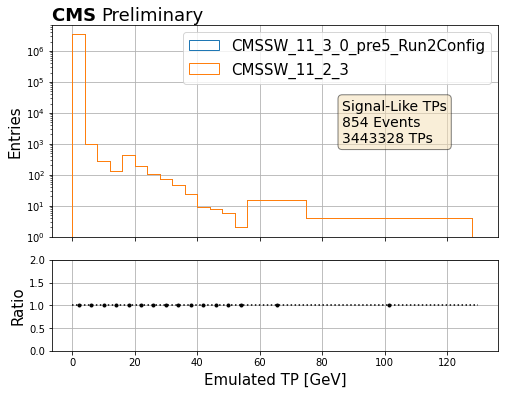

Getting variable values...
bins: [0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24.0, 28.0, 32.0, 36.0, 40.0, 44.0, 48.0, 52.0, 56.0, 75.0, 128.0]
NUMBER OF TPs: [0.  0.  0.  ... 0.  0.  0.5]
Producing numpy histograms...
Taking ratio...
Saving File: /eos/user/a/atishelm/www/EcalL1Optimization/Emulator/TestETTAnalyzer//Ratio_threefour_Run2.png
Saving File: /eos/user/a/atishelm/www/EcalL1Optimization/Emulator/TestETTAnalyzer//Ratio_threefour_Run2.png


<ipython-input-4-a2ba71023f47>:188: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


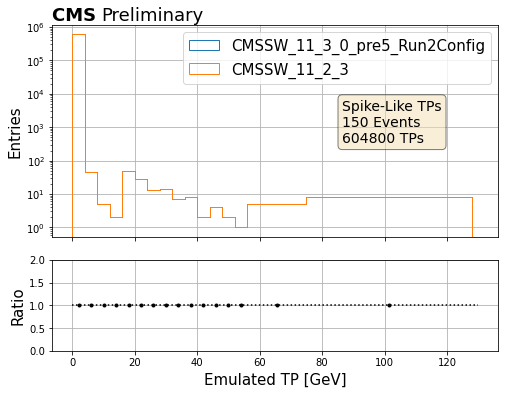

Getting variable values...
bins: [0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24.0, 28.0, 32.0, 36.0, 40.0, 44.0, 48.0, 52.0, 56.0, 75.0, 128.0]
NUMBER OF TPs: [0.  0.  0.  ... 0.  0.  0.5]
Producing numpy histograms...
Taking ratio...
Saving File: /eos/user/a/atishelm/www/EcalL1Optimization/Emulator/TestETTAnalyzer//Ratio_threefour_ZeroingConfig.png
Saving File: /eos/user/a/atishelm/www/EcalL1Optimization/Emulator/TestETTAnalyzer//Ratio_threefour_ZeroingConfig.png


<ipython-input-4-a2ba71023f47>:188: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


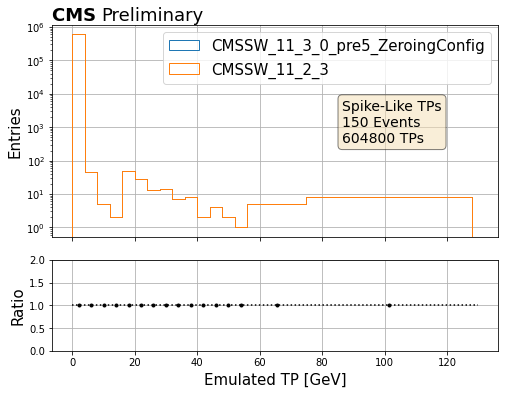

DONE


In [5]:
##-- Create ratio plots to check for changes in quantities between ETTAnalyzer files - for checking for differences between CMSSW emulator versions 
ol = '/eos/user/a/atishelm/www/EcalL1Optimization/Emulator/TestETTAnalyzer/' ##-- Output location for plots 
variable = "twrEmul3ADC" ##-- Variable to plot. twrEmul3ADC: Emulated TP at BX0 

##-- Ratio between severity zero outputs (one file per CMSSW config)
##-- Expect no difference in this case 

PrevEmulatorPath = "ETTAnalyzer_ntuples_noOddPeakFinder/ETTAnalyzer_CMSSW_11_2_3_Sevzero.root"
NewEmulator_Run2ConfigPath = "ETTAnalyzer_Outputs/ETTAnalyzer_CMSSW_11_3_0_pre5_Sevzero_Run2Config.root"

label_1 = "CMSSW_11_3_0_pre5_Run2Config"
label_2 = "CMSSW_11_2_3"

files_1 = [NewEmulator_Run2ConfigPath, PrevEmulatorPath]
files_2 = []

Ratio(files_1, label_1, label_2, "zero", "Run2", ol, variable)

##-- Ratio between spikes (two files per CMSSW config. One for severity 3, one for severity 4)
##-- Ratio where Run 2 config is used in updated emulator 
##-- Expect no difference in this case 

label_1 = "CMSSW_11_3_0_pre5_Run2Config"
label_2 = "CMSSW_11_2_3"

files_2 = [
    "ETTAnalyzer_Outputs/ETTAnalyzer_CMSSW_11_3_0_pre5_Sevthree_Run2Config.root",
    "ETTAnalyzer_Outputs/ETTAnalyzer_CMSSW_11_3_0_pre5_Sevfour_Run2Config.root",
    "ETTAnalyzer_ntuples_noOddPeakFinder/ETTAnalyzer_CMSSW_11_2_3_Sevthree.root",
    "ETTAnalyzer_ntuples_noOddPeakFinder/ETTAnalyzer_CMSSW_11_2_3_Sevfour.root"
]


Ratio(files_2, label_1, label_2, "threefour", "Run2", ol, variable)

##-- Ratio between spikes (two files per CMSSW config. One for severity 3, one for severity 4)
##-- Ratio where candidate zeroing config is used in updated emulator 
##-- Expect some difference in this case --> For this particular default file config, they may be equal as an artifact from CMSSW merge request debugging 

label_1 = "CMSSW_11_3_0_pre5_ZeroingConfig"
label_2 = "CMSSW_11_2_3"

files_2 = [
    "ETTAnalyzer_Outputs/ETTAnalyzer_CMSSW_11_3_0_pre5_Sevthree_Run3Config.root",
    "ETTAnalyzer_Outputs/ETTAnalyzer_CMSSW_11_3_0_pre5_Sevfour_Run3Config.root",
    "ETTAnalyzer_ntuples_noOddPeakFinder/ETTAnalyzer_CMSSW_11_2_3_Sevthree.root",
    "ETTAnalyzer_ntuples_noOddPeakFinder/ETTAnalyzer_CMSSW_11_2_3_Sevfour.root"
]

Ratio(files_2, label_1, label_2, "threefour", "ZeroingConfig", ol, variable)

print("DONE")

Severity: zero
filePath: ETTAnalyzer_Outputs/ETTAnalyzer_CMSSW_11_3_0_pre5_Sevzero_Run2Config.root
outLabel: CMSSW_11_3_0_pre5_Sevzero_Run2Config


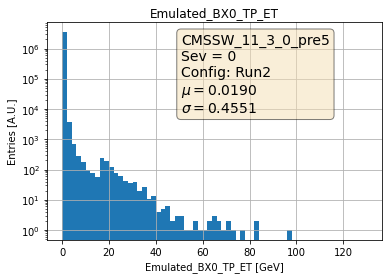

Severity: three
filePath: ETTAnalyzer_Outputs/ETTAnalyzer_CMSSW_11_3_0_pre5_Sevthree_Run2Config.root
outLabel: CMSSW_11_3_0_pre5_Sevthree_Run2Config


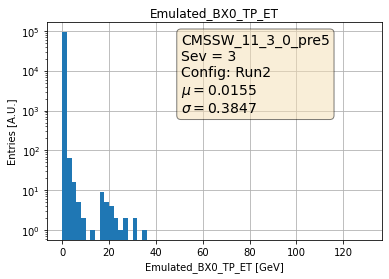

Severity: four
filePath: ETTAnalyzer_Outputs/ETTAnalyzer_CMSSW_11_3_0_pre5_Sevfour_Run2Config.root
outLabel: CMSSW_11_3_0_pre5_Sevfour_Run2Config


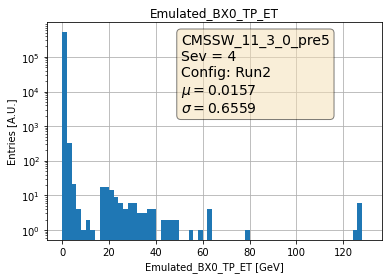

DONE


In [6]:
##-- Produce 1D plots of variables for each configuration 
SevLevels = ["zero", "three", "four"] ##-- Severity levels to plot 
variables = ["twrEmul3ADC"] ##-- Variables to plot 
CMSSW_versions = ["CMSSW_11_3_0_pre5"] ##-- CMSSW configs to plot - expected in file names 
Configs = ["Run2Config"] ##-- Emulator configurations to plot - expected in file names 

ol = '/eos/user/a/atishelm/www/EcalL1Optimization/Emulator/TestETTAnalyzer/' ##-- output location 
for Sev in SevLevels:
    print("Severity:",Sev)
    for CMSSW_V in CMSSW_versions:
        
        ##-- Only Run 2 config for previous CMSSW release with no further emulator development 
        if(CMSSW_V == "CMSSW_11_2_3"):
            Config = ""
            filePath = "ETTAnalyzer_Outputs/ETTAnalyzer_%s_Sev%s.root"%(CMSSW_V, Sev)
            outLabel = "%s_Sev%s"%(CMSSW_V, Sev)
            Plot1D(filePath, variables, ol, outLabel, Sev, Config)
            
        ##-- Two configurations for current emulator development 
        elif(CMSSW_V == "CMSSW_11_3_0_pre5"):
            for Config in Configs:
                filePath = "ETTAnalyzer_Outputs/ETTAnalyzer_%s_Sev%s_%s.root"%(CMSSW_V, Sev, Config)
                outLabel = "%s_Sev%s_%s"%(CMSSW_V, Sev, Config)
                Config = Config.replace("Config", "")
                Plot1D(filePath, variables, ol, outLabel, Sev, Config)
    
print("DONE")

ET Cut: 0
Severity: zero
--> Variable: twrEmul3ADC


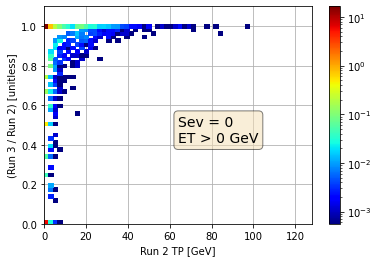

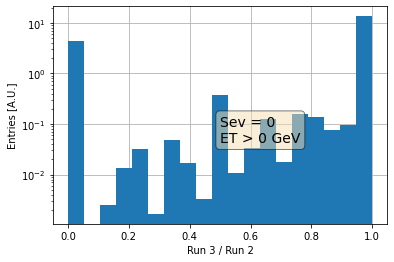

Severity: three
--> Variable: twrEmul3ADC


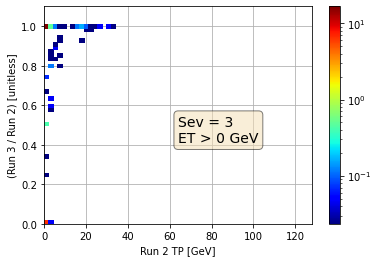

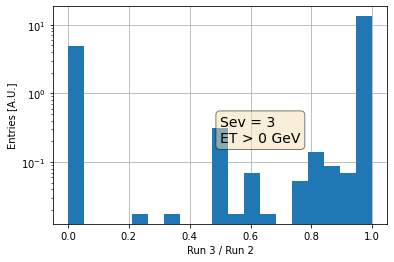

Severity: four
--> Variable: twrEmul3ADC


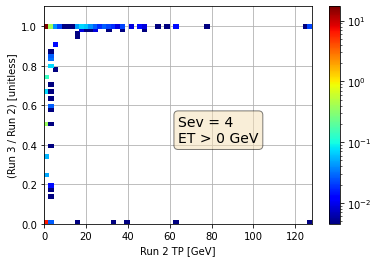

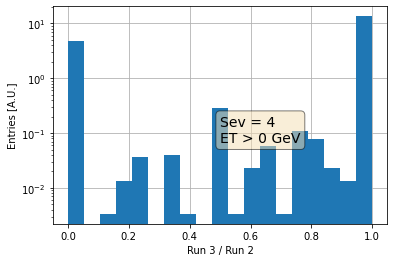

ET Cut: 16
Severity: zero
--> Variable: twrEmul3ADC


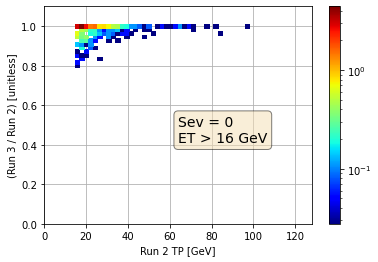

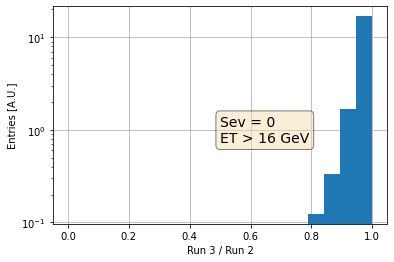

Severity: three
--> Variable: twrEmul3ADC


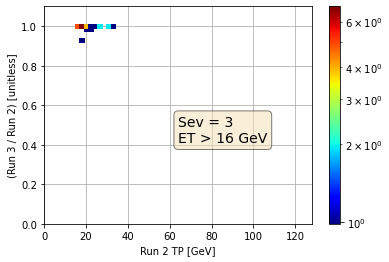

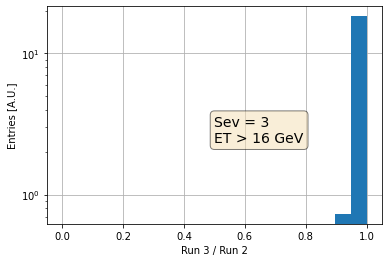

Severity: four
--> Variable: twrEmul3ADC


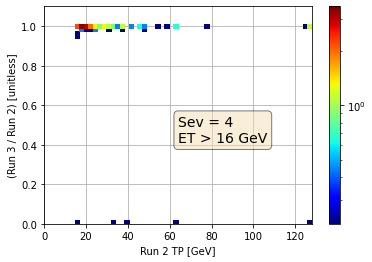

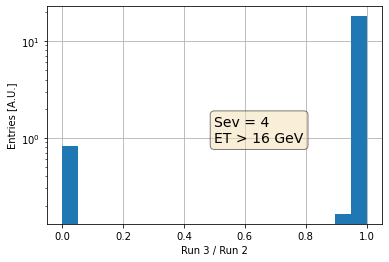

DONE


In [7]:
##-- Plot ratio of Run 3 config over Run 2 config vs twrEmul3ADC energy 
##-- These plots show which TPs are affected by any emulator updates and how their quantities change 

ol = '/eos/user/a/atishelm/www/EcalL1Optimization/Emulator/TestETTAnalyzer/'
variables = ["twrEmul3ADC"]
ET_CUTS = [0, 16] ##-- Produce plot with cut at 0 and 16 GeV 
SevDict = {
    "zero" : "0", 
    "three" : "3",
    "four" : "4"
}

for ET_CUT in ET_CUTS:
    print("ET Cut:",ET_CUT)
    for Sev in ["zero", "three", "four"]:
        print("Severity:",Sev)
        SevNum = SevDict[Sev]

        ##-- Paths
        ##-- Paths are a bit hardcoded here and could be made more general. Or not. Maybe setting individual paths for files can be helpful. Up to the user 
        Run2_path = "ETTAnalyzer_ntuples_noOddPeakFinder/ETTAnalyzer_CMSSW_11_3_0_pre1_Sev%s_Run2Config.root"%(Sev)
        Run3_path = "ETTAnalyzer_ntuples_OddPeakFinder/ETTAnalyzer_CMSSW_11_3_0_pre1_Sev%s_Run3Config.root"%(Sev)
        
#         Run2_path = "ETTAnalyzer_Outputs/ETTAnalyzer_CMSSW_11_3_0_pre5_Sev%s_Run2Config.root"%(Sev)
#         Run3_path = "ETTAnalyzer_Outputs/ETTAnalyzer_CMSSW_11_3_0_pre5_Sev%s_Run3Config.root"%(Sev)

        ##-- Files 
        Run2_file = uproot.open(Run2_path)
        Run3_file = uproot.open(Run3_path) 

        for var in variables:
            print("--> Variable:",var)
            Run2_vals_ = Run2_file['tuplizer']['ETTAnalyzerTree'][var].array()
            Run3_vals_ = Run3_file['tuplizer']['ETTAnalyzerTree'][var].array()

            ##-- Combine event entries into single list 
            Run2_vals_all = np.array([val / 2. for event in Run2_vals_ for val in event], dtype=float) ##-- Divide by 2 for 'ADC' to GeV 
            Run3_vals_all = np.array([val / 2. for event in Run3_vals_ for val in event], dtype=float)

            ##-- Remove entries where TP = 0 
            Run2_Val_Mask = [Run2_vals_all > ET_CUT]
            Run2_vals_all = Run2_vals_all[tuple(Run2_Val_Mask)]
            Run3_vals_all = Run3_vals_all[tuple(Run2_Val_Mask)]   

            Run3_vals = np.array(Run3_vals_all, dtype=float)
            Run2_vals = np.array(Run2_vals_all, dtype=float)        
            Run3_Over_Run2 = np.divide(Run3_vals, Run2_vals, out=np.zeros_like(Run3_vals), where=Run2_vals!=0)

            ##-- Set Binning
            xmin, xmax, xbins = 0, 128, 60
            ymin, ymax, ybins = 0, 1.1, 60
            xbinSpace = np.linspace(xmin, xmax, xbins + 1)
            ybinSpace = np.linspace(ymin, ymax, ybins + 1)

            ##-- Prepare Text Box 
            textstr = '\n'.join((
                "Sev = %s"%(SevNum),
                "ET > %s GeV"%(ET_CUT)))   
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)        

            ##-- Entries vs. Ratio
            fig, ax = plt.subplots()
            h = ax.hist2d(
                x = Run2_vals, 
                y = Run3_Over_Run2, 
                density = True, 
                bins = [xbinSpace, ybinSpace], 
                cmap = 'jet', 
                norm = LogNorm(),
    #             cmin = 0.0001 ##-- Do not plot color for bins with entries < 0.5 
            ) 
            plt.colorbar(h[3], ax=ax)
            ax.text(0.5, 0.5, textstr, transform=ax.transAxes, fontsize=14,
                    verticalalignment='top', bbox=props)             
            plt.xlabel("Run 2 TP [GeV]")
            plt.ylabel("(Run 3 / Run 2) [unitless]")
            plt.grid(True)
            plt.show()
            plt.savefig("%s/Run2_Run3_TP_Ratio_Sev%s_ETgt%sGeV.png"%(ol, Sev, ET_CUT))
            plt.savefig("%s/Run2_Run3_TP_Ratio_Sev%s_ETgt%sGeV.pdf"%(ol, Sev, ET_CUT))
            plt.close()     

            ##-- Prepare Text Box 
            textstr = '\n'.join((
                "Sev = %s"%(SevNum),
                "ET > %s GeV"%(ET_CUT)))   
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)                

            bins = np.linspace(0, 1, 20)
            fig, ax = plt.subplots()
            plt.hist(Run3_Over_Run2, bins = bins, density = True, label = "Run 3 Over Run 2 TP ET")
            plt.xlabel("Run 3 / Run 2")
            plt.ylabel("Entries [A.U.]")
            ax.text(0.5, 0.5, textstr, transform=ax.transAxes, fontsize=14,
                    verticalalignment='top', bbox=props)             
            plt.yscale('log')
            plt.grid(True)
            plt.show()
            plt.savefig("%s/1D_Run2_Run3_TP_Ratio_Sev%s_ETgt%sGeV.png"%(ol, Sev, ET_CUT))
            plt.savefig("%s/1D_Run2_Run3_TP_Ratio_Sev%s_ETgt%sGeV.pdf"%(ol, Sev, ET_CUT))
            plt.close()
        

print("DONE")

In [17]:
##-- For checking entry by entry that all values are equal between CMSSW versions 
var_ = "twrADC"

for Sev in ["zero", "three", "four"]:
    print("Severity:",Sev)

    ##-- Paths to ETTAnalyzer files 
    path1 = "ETTAnalyzer_ntuples_noOddPeakFinder/ETTAnalyzer_CMSSW_11_2_3_Sev%s.root"%(Sev)
    path2 = "ETTAnalyzer_Outputs/ETTAnalyzer_CMSSW_11_3_0_pre5_Sev%s_Run2Config.root"%(Sev)
    path3 = "ETTAnalyzer_Outputs/ETTAnalyzer_CMSSW_11_3_0_pre5_Sev%s_Run3Config.root"%(Sev)

    ##-- Obtain variable values with uproot
    file1 = uproot.open(path1)
    vals1 = file1['tuplizer']['ETTAnalyzerTree'][var_].array()
    all_vals1 = [val for event in vals1 for val in event] ##-- Combine all event values into a single list 

    file2 = uproot.open(path2)
    vals2 = file2['tuplizer']['ETTAnalyzerTree'][var_].array()
    all_vals2 = [val for event in vals2 for val in event] ##-- Combine all event values into a single list 

    file3 = uproot.open(path3)
    vals3 = file3['tuplizer']['ETTAnalyzerTree'][var_].array()
    all_vals3 = [val for event in vals3 for val in event] ##-- Combine all event values into a single list 

    CMSSW_11_2_3_Minus_CMSSW_11_3_0_pre5 = np.subtract(np.array(all_vals1), np.array(all_vals2)) ##-- compute entry-by-entry TP difference 
    zero_mask = [CMSSW_11_2_3_Minus_CMSSW_11_3_0_pre5 != 0] ##-- create mask to remove any entries which equal 0 (this means they are equal between CMSSW configs)
    print("CMSSW_11_2_3:",np.array(all_vals1))
    print("CMSSW_11_3_0_pre5:",np.array(all_vals2))
    print("CMSSW_11_2_3_Minus_CMSSW_11_3_0_pre5:",CMSSW_11_2_3_Minus_CMSSW_11_3_0_pre5)
    print("BEFORE Removing zeroes: len(CMSSW_11_2_3_Minus_CMSSW_11_3_0_pre5):",len(CMSSW_11_2_3_Minus_CMSSW_11_3_0_pre5))

    CMSSW_11_2_3_Minus_CMSSW_11_3_0_pre5 = CMSSW_11_2_3_Minus_CMSSW_11_3_0_pre5[tuple(zero_mask)]

    print("AFTER removing zeroes: len(CMSSW_11_2_3_Minus_CMSSW_11_3_0_pre5):",len(CMSSW_11_2_3_Minus_CMSSW_11_3_0_pre5))

print("DONE")

Severity: zero
CMSSW_11_2_3: [0 0 0 ... 0 0 0]
CMSSW_11_3_0_pre5: [0 0 0 ... 0 0 0]
CMSSW_11_2_3_Minus_CMSSW_11_3_0_pre5: [0 0 0 ... 0 0 0]
BEFORE Removing zeroes: len(CMSSW_11_2_3_Minus_CMSSW_11_3_0_pre5): 3443328
AFTER removing zeroes: len(CMSSW_11_2_3_Minus_CMSSW_11_3_0_pre5): 0
Severity: three
CMSSW_11_2_3: [0 0 0 ... 0 0 0]
CMSSW_11_3_0_pre5: [0 0 0 ... 0 0 0]
CMSSW_11_2_3_Minus_CMSSW_11_3_0_pre5: [0 0 0 ... 0 0 0]
BEFORE Removing zeroes: len(CMSSW_11_2_3_Minus_CMSSW_11_3_0_pre5): 92736
AFTER removing zeroes: len(CMSSW_11_2_3_Minus_CMSSW_11_3_0_pre5): 0
Severity: four
CMSSW_11_2_3: [0 0 0 ... 0 0 1]
CMSSW_11_3_0_pre5: [0 0 0 ... 0 0 1]
CMSSW_11_2_3_Minus_CMSSW_11_3_0_pre5: [0 0 0 ... 0 0 0]
BEFORE Removing zeroes: len(CMSSW_11_2_3_Minus_CMSSW_11_3_0_pre5): 512064
AFTER removing zeroes: len(CMSSW_11_2_3_Minus_CMSSW_11_3_0_pre5): 0
DONE
